# Solving an UD-MIS problem using QAA

In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

import pulser

## Introduction 

In this tutorial, we illustrate how to solve the Maximum Independent Set (MIS) problem on a platform of Rydberg atoms in analog mode, using Pulser. 

For more details about this problem and how to encode it on a Rydberg atom quantum processor, see [Pichler, et al., 2018](https://arxiv.org/abs/1808.10816), [Henriet, 2020]( https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.012335) and [Dalyac, et al., 2020]( https://arxiv.org/abs/2012.14859).

Consider an undirected graph composed of a set of vertices connected by unweighted edges. An independent set of this graph is a subset of vertices where any two elements of this subset are not connected by an edge. The Maximum Independent Set (MIS) corresponds to the largest of such subsets, and it is in general an NP-complete problem to determine the MIS of a graph. 

The MIS problem has several interesting applications, such as portfolio diversification in
finance, or broadcast systems (wifi or cellular network) optimization.

For example, assume an ensemble of identical radio transmitters over French cities that each have the same radius of transmission. It was quickly realized that two transmitters with close or equal frequencies could interfere with one another, hence the necessity to assign non-interfering frequencies to overlapping transmiting towers. Because of the limited amount of bandwidth space, some towers have to be assigned the same or close frequencies. The MIS of a graph of towers indicate the maximum number of towers that can have close or equal given frequency (red points). 

<center>
<img src="attachment:France_MIS.png" alt="MIS map France" width="650">
</center>

Here, we will show how to solve the MIS problem on Unit-Disk (UD) graphs with an excellent approximation.

When looking for the MIS of a graph, we separate the nodes into two distinct classes: an independence one and the others. We can attribute a status $z$ to each node, where $z_i = 1$  if node $i$ is attributed to the independent set, and $z_i=0$ otherwise. The Maximum Independent Set corresponds to  the minima of the following cost function: 

$$
C(z_1,\dots,z_N) = -\sum_{i=1}^N z_i + U \sum_{\langle i,j \rangle}z_i z_j
$$

where $U \gg 1$  and $\langle i,j \rangle$ represents adjacent nodes (i.e. there is a link between node $i$ and $j$). In this cost function, we want to promote a maximal number of atoms to the $1$ state, but the fact that $U \gg 1$  strongly penalizes two adjacent vertices in state $1$. The minimum of $C(z_0,\dots,z_N)$ therefore corresponds to the maximum independent set of the graph.

Interestingly, the operator $\hat{C}$ associated with the cost function of the previous equation can be natively realized on a neutral atom platform with some constraints on the graph edges. We map a  ground state and a Rydberg state of each atom to a two-level system, where $|1 \rangle = |r \rangle$ is a Rydberg state and $|0 \rangle = |g \rangle$ is a ground state. An atom in a Rydberg state has an excited electron with a very high principal quantum number and therefore exhibits a large electric dipole moment. As such, when two atoms are excited to Rydberg states, they exhibit a strong van der Waals interaction. Placing $N$ atoms at positions $\textbf{r}_j$ in a 2D plane, and coupling the ground state $|0\rangle$ to the Rydberg state $|1\rangle$ with a laser system enables the realization of the Hamiltonian :

$$
H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \hbar \delta n_i +\sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j.
$$

Here, $\Omega$ and $\delta$ are respectively the Rabi frequency and detuning of the laser system and $\hbar$ is the reduced Planck constant. The first two terms of the equation govern the transition between states $|0\rangle$ and $|1 \rangle$ induced by the laser, while the third term represents the repulsive Van der Waals interaction between atoms in the $|1\rangle$ state. More precisely, $n_i$ counts the number of Rydberg excitations at position $i$. The interaction strength between two atoms decays as $|\textbf{r}_i-\textbf{r}_j|^{-6}$.

### A UD-graph out of an atomic register

We now illustrate how one can use Pulser and a neutral-atom device to find the MIS of a UD-graph. Since the quantum platform is emulated in this notebook, we restrict the number of atoms to 5, just to show a proof-of-concept. 

Taking the positions of the 5 atoms, we create the atomic register:

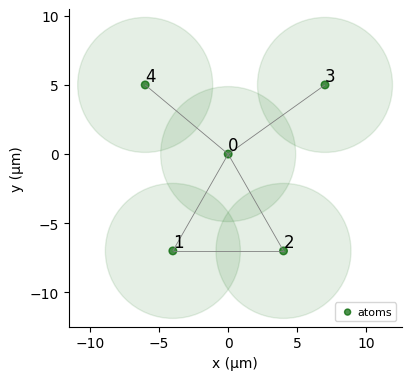

In [2]:
pos = np.array([[0.0, 0.0], [-4, -7], [4, -7], [7, 5], [-6, 5]])

qubits = dict(enumerate(pos))

reg = pulser.Register(qubits)
reg.draw(
    blockade_radius=pulser.AnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

A link in the graph corresponds to two atoms that are within the Rydberg Blockade Radius (RBR) of each other. The RBR is directly linked to the Rabi frequency $\Omega$ and is obtained using `AnalogDevice.rydberg_blockade_radius()`. For now, we assume that $\Omega=1~\text{rad}/\mu s$ in the calculation.

We drew our register with half-radius circles around the atoms to highlight the crossing of each one's blockade radius, thus forming a linked graph of interacting qubits.

This graph has two maximal independent sets: $(1,3,4)$ and $(2,3,4)$, respectively `01011` and `00111` in binary. 

Now that the graph is encoded in the Register and that we know there is a direct relation between the Ising Hamiltionian $H$ and the cost function $C$, we still have to build a quantum algorithm that outputs the maximal independent sets. To do so, we resort to the Quantum Adiabatic Algorithm (QAA).

## Quantum Adiabatic Algorithm

The idea behind the adiabatic algorithm (see [Albash, Lidar, 2018](https://arxiv.org/pdf/1611.04471.pdf)) is to slowly evolve the system from an easy-to-prepare groundstate to the groundstate of the cost Hamiltonian $H_C$. If done slowly enough, the system of atoms stays in the instantaneous ground-state.

In our case, we continuously vary the parameters $\Omega(t), \delta(t)$ in time, starting with $\Omega(0)=0, \delta(0)<0$ and ending with $\Omega(0)=0, \delta>0$. 

Notice how, when $\delta(0)<0$, the more atoms there are in the $|0\rangle$ state, the lower the energy is; as such, the ground-state of $H(0)$ matches the initial state $|00000\rangle$. 

However, when $\delta(0)>0$, having atoms in the $|1\rangle$ will now lower the total energy as long as their close neighbours are not themselves in the $|1\rangle$ state, which would increase the total energy through the interaction energy. In this way, the ground-state of $H(t_f)$ will maximize the number of atoms in the $|1\rangle$ state while avoiding interactions, thus corresponding to the ground-state of $H_c$.

### Finding the right parameters

To ensure that we are not exciting the system to states that do not form independent sets, we have to estimate the minimal distance between atoms which are not connected in the graph (this yields $\Omega_{\text{min}}$), and estimate the furthest distance between two disconnected atoms $\Omega_{\text{max}}$. Keeping $\Omega \in [\Omega_{\text{min}}, \Omega_{\text{max}}]$ ensures that only independent sets appear in the dynamics. 

In [4]:
# The Rydberg blockade radius we used to define the connectivity
rb = pulser.AnalogDevice.rydberg_blockade_radius(1.0)
# Coordinates of all the qubits
coordinates = list(reg.qubits.values())
# Distances between two qubits
qubit_dists = pdist(coordinates)
# Whether two qubits are close enough to be linked
are_linked = qubit_dists < rb
# Maximum distance between linked atoms
link_max = np.max(qubit_dists[are_linked])
# Minimum distances between unlinked atoms
no_link_min = np.min(qubit_dists[~are_linked])
# Valid ranges for Omega
omega_min = pulser.AnalogDevice.interaction_coeff / no_link_min**6
omega_max = pulser.AnalogDevice.interaction_coeff / link_max**6
print(f"Valid range for Omega: [{omega_min}, {omega_max}] rad/μs")

Valid range for Omega: [0.2670507608137722, 2.1364060865101773] rad/μs


In [5]:
# We choose a value between the min and the max
omega = (omega_max + omega_min) / 2
delta_0 = -4  # just has to be negative
delta_f = -delta_0  # just has to be positive
duration = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

We now verify that our chosen value for $\Omega$ preserves the original connectivity of our register:

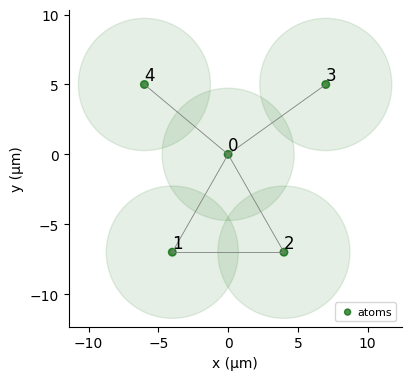

In [7]:
reg.draw(
    blockade_radius=pulser.AnalogDevice.rydberg_blockade_radius(omega),
    draw_graph=True,
    draw_half_radius=True,
)

### Building the Sequence

We are now ready to build our pulse sequence. We make a single pulse, where $\Omega$ and $\delta$ vary slowly and smoothly between the values we outlined above.

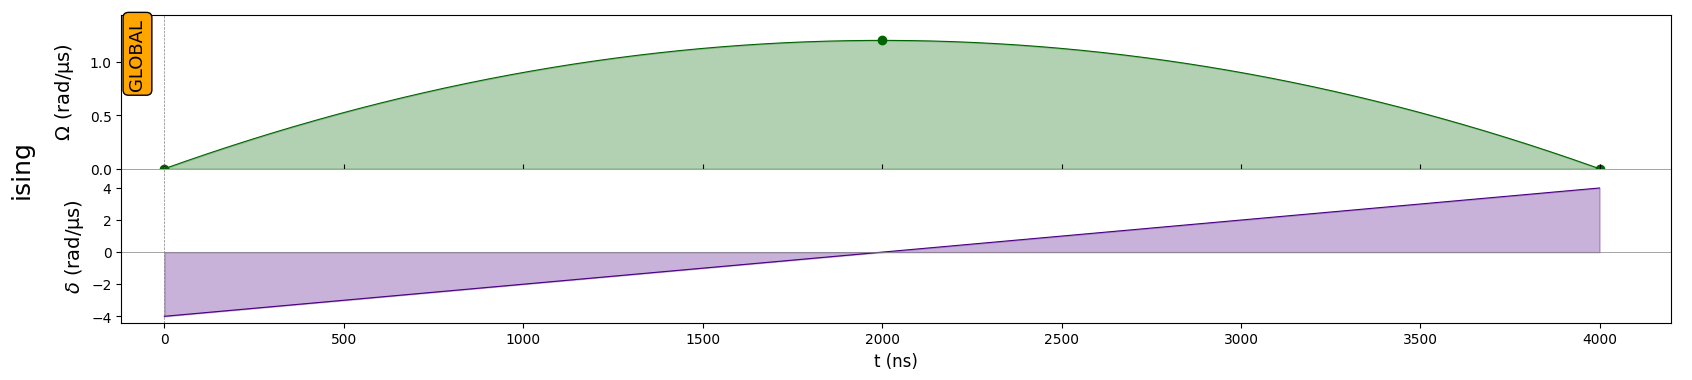

In [8]:
seq = pulser.Sequence(reg, pulser.AnalogDevice)
dt = seq.declare_variable("dt", dtype=int)

adiabatic_pulse = pulser.Pulse(
    pulser.InterpolatedWaveform(dt, [1e-9, omega, 1e-9]),
    pulser.RampWaveform(dt, delta_0, delta_f),
    0,
)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")

built_seq = seq.build(dt=duration)
built_seq.draw(mode="input")

### Generating the results

With our sequence in hand, we can now emulate its execution to get our results. To do so, we will use `QutipBackend`:

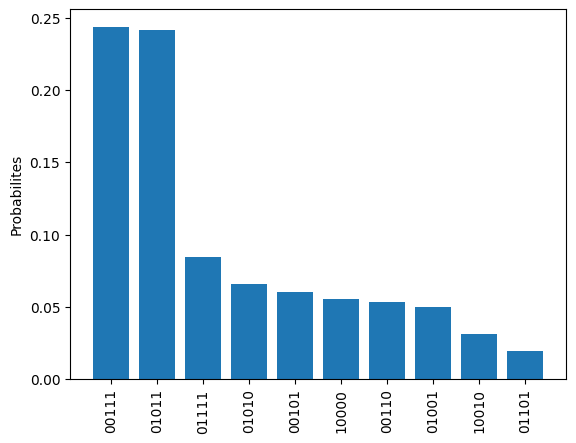

In [9]:
backend = pulser.backends.QutipBackend(built_seq)
results = backend.run()
final_result = results[-1]
final_result.plot_histogram(max_n_bitstrings=10)

The most-likely states are `01011` and `00111`, which correspond to the two MIS of the graph. 

__Not deleting this for now, but I think the added complexity is not worth it__

### How does the time evolution affect the quality of the results? 

You may have noticed we mentioning that the QAA approach requires us to vary the Hamiltonian _slowly enough_ which begs the question, how slow is slow enough? In this toy model, we can assess this by scanning the duration of our sequence and seeing how this affects the quality of our results.

We estimate the cost of a sampled state vector by making an average over the samples. This is done by taking the corresponding bitstring ${\bf z}=(z_1, \ldots, z_N)$ and calculating

$$
C({\bf z}) = - \sum_i z_i + \sum_{i\geq j} pA_{ij}z_iz_j  = p\,({\bf z}^\top \cdot A^\textsf{U} \cdot {\bf z}) - |{\bf z}|_0,
$$

where $A^\textsf{U}$ is the upper triangular part of the adjacency matrix of the graph, $|\cdot|_0$ gives the sum of non-zero terms of the bitstring, and $p$ is the "penalty" introduced by the magnitude of the quadratic term.

Determining the cost of a given bitstring takes polynomial time. The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

In [69]:
def pos_to_adjacency_matrix(pos, omega):
    rb = pulser.AnalogDevice.rydberg_blockade_radius(omega)
    n_vertices = len(pos)
    adj = np.zeros((n_vertices, n_vertices))
    for m, n in itertools.combinations(range(n_vertices), r=2):
        if np.linalg.norm(pos[m] - pos[n]) < rb:
            adj[m, n] = 1
    return adj

In [73]:
def get_cost_colouring(bitstring, pos, penalty=10):
    z = np.array(list(bitstring), dtype=int)
    A = pos_to_adjacency_matrix(pos, 1.0)
    # Add penalty and bias:
    cost = penalty * (z.T @ np.triu(A) @ z) - np.sum(z)
    return cost


def get_cost(counter, pos):
    cost = sum(counter[key] * get_cost_colouring(key, pos) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [75]:
cost = []
for dt in np.linspace(1, 4, 10) * 1000:
    built_seq = seq.build(dt=dt)
    backend = pulser.backends.QutipBackend(built_seq)
    results = backend.run()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, pos) / 3)

/home/henrique/git/Pulser/pulser-core/pulser/sequence/sequence.py:1374: UserWarning: A duration of 1333 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 1336 ns.
  self._add(pulse, channel, protocol)
/home/henrique/git/Pulser/pulser-core/pulser/sequence/sequence.py:1374: UserWarning: A duration of 1666 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 1668 ns.
  self._add(pulse, channel, protocol)
/home/henrique/git/Pulser/pulser-core/pulser/sequence/sequence.py:1374: UserWarning: A duration of 2333 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 2336 ns.
  self._add(pulse, channel, protocol)
/home/henrique/git/Pulser/pulser-core/pulser/sequence/sequence.py:1374: UserWarning: A duration of 2666 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 2668 ns.
  self._add(pulse, channel, protocol)
/home/henrique/git/Pulser/pulser-core/pulser/sequence/sequence.py:1374: User

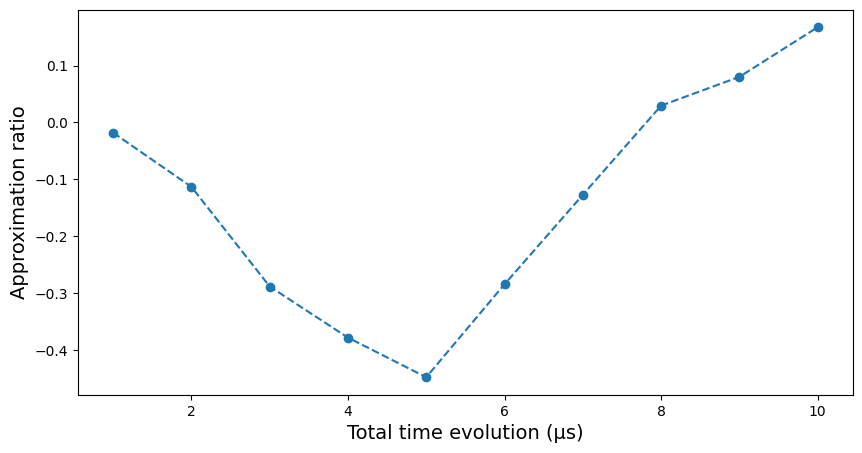

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), -np.array(cost), "--o")
plt.xlabel("Total time evolution (µs)", fontsize=14)
plt.ylabel("Approximation ratio", fontsize=14)
plt.show()